# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** ("meaning from context").
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive

---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?
2. What does the phrase **"meaning emerges from co-occurrence patterns"** mean to you?

1. Main limitation of one-hot vectors: One-hot vectors are high-dimensional and sparse (mostly zeros), which is memory-inefficient and computationally expensive. More importantly, they fail to capture semantic relationships between words—every word is equally distant from every other word in the vector space, so there's no way to represent similarity or meaning overlap.
2. "Meaning emerges from co-occurrence patterns": This captures the distributional hypothesis—the idea that words with similar contexts (words they frequently appear near) tend to have similar meanings. For example, "physician" and "doctor" often appear with words like "patient," "hospital," and "treatment," which allows us to infer they are semantically related even without a dictionary definition.

---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.

In [2]:
# Install required libraries (run once)
%pip -q install gensim scikit-learn nltk matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [4]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VinceT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VinceT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups

In [5]:
# TODO: Load the dataset
# Use fetch_20newsgroups with subset="train" and remove=("headers", "footers", "quotes")
# Store the data in a variable called 'data' and documents in 'documents'
# load dataset
data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
documents = data.data

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.

In [6]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    # TODO: Implement the preprocessing steps
    # 1. Lowercase and tokenize using word_tokenize
    # 2. Filter to keep only alphabetic tokens that are not stopwords
    
    # 1. Lowercase and tokenize using word_tokenize
    tokens = word_tokenize(text.lower())
    # 2. Filter to keep only alphabetic tokens that are not stopwords
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
 
    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?
2. Name one situation where removing stopwords could be a bad idea.

1. Why remove stopwords in this lab?\
Removing stop words can reduce noise and emphasize content words that carry topical/semantic information. This typically improves training speed and makes neighborhoods in embedding space more meaningful for a small corpus.

2. When could removing stopwords be bad?\
If function words carry task-relevant signals (e.g., authorship attribution, stylistic analysis, some syntactic tasks), or in resource constrainted settings where every token helps, or for languages/contexts where stopwords are ambiguous and may carry meaning, removing stop words may be a bad thing to do.

---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **"You shall know a word by the company it keeps."** (J. R. Firth)

In practice:
- a word's **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.

---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.

In [7]:
# TODO: Train Word2Vec (Skip-gram)
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1

w2v = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1
)

print("Vocabulary size:", len(w2v.wv))

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.

In [8]:
# TODO: Inspect the first 10 values of the word vector for "computer"
# Use w2v.wv["computer"] to access the vector

print("First 10 dims of 'computer':")
print(w2v.wv["computer"][:10])


First 10 dims of 'computer':
[ 0.09991564  0.34163588 -0.33299637  0.45666826 -0.19078296 -0.8005631
 -0.34868106  0.24300317  0.61886656 -0.18378034]


### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *"motel"*, we may want to retrieve documents about *"hotel"*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.

In [9]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)

# YOUR CODE HERE - iterate through the results and print each word and score
target = "computer"
print(f"Most similar words to '{target}':")
for word, score in w2v.wv.most_similar(target, topn=10):
    print(f"{word:15s}  {score:.3f}")


Most similar words to 'computer':
engineering      0.715
transmits        0.692
shopper          0.680
programmer       0.680
isdn             0.674
mainframe        0.674
bulletin         0.672
networks         0.671
electronic       0.661
dsp              0.660


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?
2. Pick 1 surprising neighbor and propose a reason it might appear.

1. The neighbors usually reflect both topic and functional similarity (e.g., pc, computing, software, hardware, unix).
2. A surprising neighbour (e.g., a brand or acronym) might appear because it co-occurs in similar contexts (e.g., discussions about drivers, installations, or file systems), even if it’s not strictly a synonym.

---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [10]:
# TODO: Perform analogy using vector arithmetic
# Use w2v.wv.most_similar(positive=[...], negative=[...], topn=5)
# Try: king - man + woman = ?

# YOUR CODE HERE
try:
    analogy = w2v.wv.most_similar(
        positive=["king", "woman"],
        negative=["man"],
        topn=5
    )
    print("Analogy results for: king - man + woman ≈ ?")
    for w, s in analogy:
        print(f"{w:15s}  {s:.3f}")
except KeyError as e:
    print("A required word is missing from the vocabulary:", e)


Analogy results for: king - man + woman ≈ ?
deposition       0.775
prince           0.755
rage             0.754
rodney           0.752
bethlehem        0.746


### Why "queen" might not appear

- **Training corpus matters** — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- **Corpus size** — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words.

- **Context diversity** — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts.

In [11]:
# Check if "queen" is in the vocabulary
"queen" in w2v.wv

True

In [12]:
# TODO: Calculate the cosine similarity between the result vector and "queen"
# 1. Compute result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
# 2. Get queen_vec = w2v.wv["queen"]
# 3. Calculate cosine similarity using: np.dot(a, b) / (norm(a) * norm(b))

from numpy.linalg import norm


try:
    result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
    queen_vec  = w2v.wv["queen"]

    similarity = np.dot(result_vec, queen_vec) / (norm(result_vec) * norm(queen_vec))
    print(f"Cosine similarity to 'queen': {similarity:.4f}")
except KeyError as e:
    print("A required word is missing from the vocabulary:", e)
    
w2v.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=10)


Cosine similarity to 'queen': 0.6422


[('deposition', 0.7745953798294067),
 ('prince', 0.754915177822113),
 ('rage', 0.7540915608406067),
 ('rodney', 0.7515109181404114),
 ('bethlehem', 0.7455117702484131),
 ('ali', 0.743774950504303),
 ('gerry', 0.7431615591049194),
 ('rome', 0.7430368661880493),
 ('garden', 0.7427178025245667),
 ('mehmet', 0.7421286106109619)]

---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are "good"?
2. Give one reason analogy evaluation might not correlate with task performance.

1. Analogies can fail even with “good” embeddings due to polysemy where a word can have multiple meanings, domain mismatch where words are not commonly used or recongnized in the corpus, insufficient data, or vector space noise in a small corpus.
2. Analogy performance is an intrinsic metric and may not correlate with downstream tasks (e.g., classification, retrieval) where task-specific supervision or features dominate.



---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.

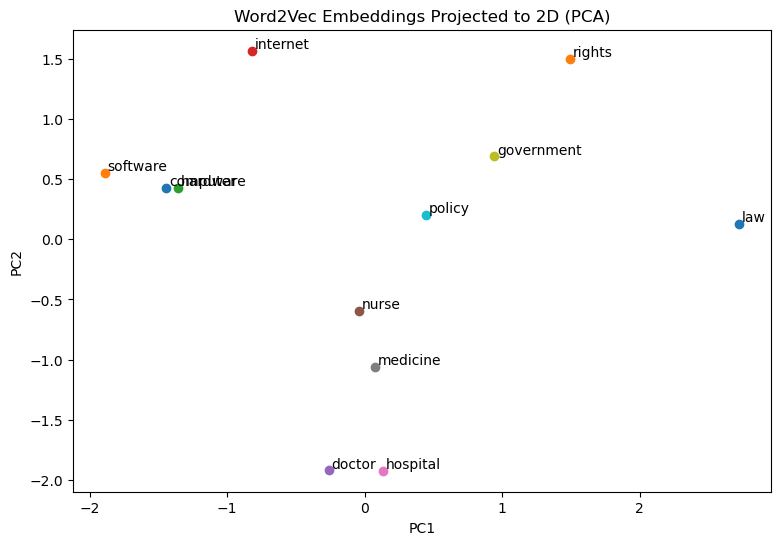

In [13]:
# TODO: Visualize word embeddings using PCA
# 1. Define a list of words to visualize
# 2. Filter to keep only words in vocabulary
# 3. Get vectors for those words
# 4. Use PCA to reduce to 2D
# 5. Plot with labels

words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

# TODO: Get vectors and apply PCA
vectors = np.array([w2v.wv[w] for w in words])

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?
2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?

1. Typically, words like (software, hardware, computer) and (doctor, nurse, hospital, medicine) are close together.

2. If clusters aren’t clear, possible reasons include small corpus, aggressive preprocessing, low vector size, or PCA distortion (2D projection can obscure true high‑dimensional structure).

---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology

In [14]:
# TODO: Train FastText on the same corpus
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4

ft = FastText(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)

print("FastText vocabulary size:", len(ft.wv))

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.

In [15]:
# TODO: Compare similarity results for "computers" between FastText and Word2Vec

query = "computers"

# FastText neighbors
print("FastText neighbors for:", query)
# YOUR CODE HERE
for word, score in ft.wv.most_similar(query, topn=10):
    print(f"{word:15s}  {score:.3f}")


# Word2Vec neighbors (check if word exists first)
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)
    # YOUR CODE HERE
    for word, score in w2v.wv.most_similar(query, topn=10):
        print(f"{word:15s}  {score:.3f}")
    
else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary.")

FastText neighbors for: computers
computes         0.970
comics           0.960
compute          0.960
compact          0.952
netware          0.943
computer         0.943
items            0.942
compuadd         0.942
competitors      0.942
company          0.938

Word2Vec neighbors for: computers
multimedia       0.904
receivers        0.874
integrated       0.855
discounts        0.852
xservers         0.850
gis              0.849
exabyte          0.849
licence          0.848
workplace        0.847
vertigo          0.846


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

---
## Part 8 — Practical mini-task: Build a tiny "semantic search" demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.

In [16]:
# TODO: Implement a semantic_neighbors function and test it with queries

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, with a friendly error message."""
    # YOUR CODE HERE
    # Check if word is in model.wv, if not return None
    # Otherwise return model.wv.most_similar(word, topn=topn)
    if word not in model.wv:
        return None
    return model.wv.most_similar(word, topn=topn)

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  airport         0.890
  northwest       0.878
  alaska          0.876
  alto            0.871
  carolina        0.869
  hawaii          0.869
  denver          0.869
  victoria        0.866

Query: space
  shuttle         0.752
  nasa            0.743
  redesign        0.681
  exploration     0.677
  goddard         0.675
  jenks           0.668
  missions        0.663
  hubble          0.660

Query: religion
  religions       0.861
  judaism         0.858
  beings          0.850
  doctrines       0.844
  mormons         0.843
  christian       0.839
  islam           0.836
  christianity    0.836

Query: graphics
  cad             0.853
  radiosity       0.843
  silicon         0.841
  gems            0.834
  packages        0.823
  iris            0.821
  assembler       0.820
  workshop        0.817


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above:
1. Would these neighbors help a search engine user?
2. What could go wrong if we deploy this directly in production?

1. Would these neighbors help a search engine user?\
Likely yes—neighbors such as motel, inn, lodging, accommodation can expand recall and retrieve relevant results that don’t match the exact query term.

2. What could go wrong in production?\
Semantic drift or polysemy could suggest off-topic terms (e.g., host in computing). There’s also risk of bias amplification, OOV gaps, or returning terms that are similar but not intent-aligned; without guardrails, this can degrade precision.

---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.

---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?
2. What is a realistic industry task where word embeddings are useful?
3. When would you choose FastText over Word2Vec?
4. What is one risk or limitation of word embeddings that a practitioner should watch for?

1) How do embeddings solve sparsity and “no similarity” issues of one-hot vectors?\
Embeddings map words to dense, low-dimensional vectors learned from data, replacing huge sparse one-hot vectors. Because training pushes words with similar contexts closer, the geometry encodes semantic similarity. This enables generalization across synonyms and reduces the curse of dimensionality.
2) A realistic industry task where word embeddings are useful:\
Semantic search / query expansion: embeddings help retrieve relevant items even when users use different vocabulary than documents (e.g., laptop vs notebook). They also help with removing duplication, provides recommendation, and clustering by grouping semantically similar content.
3) When would you choose FastText over Word2Vec?\
When you expect OOV words, typos, or morphologically rich languages. FastText’s subword modeling composes vectors from character n‑grams, which improves robustness to rare forms, misspellings, and inflections.
4) One risk/limitation to watch for:\
Embeddings can encode and amplify societal biases present in training data (e.g., gender/occupation associations). They are also domain-sensitive (poor transfer to new domains) and can fail on polysemy without context, so you should monitor, debias, and validate in real tasks.

---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.

In [22]:
# Change window to 2 and re-train FastText, then test the same queries again
ft_window2 = FastText(
    sentences=corpus,
    vector_size=100,
    window=2,  # smaller window
    min_count=5,
    workers=4
)
print("FastText (window=2) vocabulary size:", len(ft_window2.wv))

print("\nTesting queries with FastText (window=2):")
for q in queries:
    result = semantic_neighbors(ft_window2, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


FastText (window=2) vocabulary size: 18095

Testing queries with FastText (window=2):

Query: motel
  bucs            0.988
  motorola        0.984
  cartridge       0.983
  idl             0.982
  bioscom         0.979
  cdrom           0.976
  dma             0.975
  bio             0.974

Query: hotel
  flea            0.985
  frederick       0.982
  fredericks      0.980
  cambodia        0.979
  torrey          0.977
  duffey          0.976
  mccartney       0.975
  lezhgis         0.974

Query: space
  spacehab        0.978
  spacepac        0.977
  airspace        0.963
  pace            0.951
  aerospace       0.946
  spacewalk       0.930
  spacelink       0.919
  spaces          0.918

Query: religion
  christianity    0.956
  religious       0.951
  religions       0.951
  historically    0.948
  fanatic         0.945
  relief          0.945
  humanist        0.944
  theistic        0.944

Query: graphics
  graphic         0.989
  demographics    0.975
  graph           0.97

In [23]:
# repeat with window=10
ft_window10 = FastText(
    sentences=corpus,
    vector_size=100,
    window=10,  # larger window
    min_count=5,
    workers=4
)
print("FastText (window=10) vocabulary size:", len(ft_window10.wv))
print("\nTesting queries with FastText (window=10):")
for q in queries:
    result = semantic_neighbors(ft_window10, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


FastText (window=10) vocabulary size: 18095

Testing queries with FastText (window=10):

Query: motel
  hdtv            0.974
  motorola        0.972
  calculator      0.970
  iisi            0.964
  fm              0.962
  bucs            0.961
  adaptor         0.959
  ibo             0.957

Query: hotel
  canberra        0.974
  santa           0.970
  iceland         0.963
  ronald          0.958
  roland          0.956
  scotland        0.956
  daneyko         0.951
  candy           0.951

Query: space
  spacehab        0.991
  pace            0.986
  spacepac        0.985
  airspace        0.979
  spacewalk       0.974
  aerospace       0.968
  spacewalks      0.966
  spacelink       0.965

Query: religion
  behaviorists    0.978
  religions       0.974
  religious       0.973
  theologians     0.960
  relief          0.960
  humanist        0.958
  zionism         0.954
  mathematicians  0.953

Query: graphics
  graphic         0.988
  ics             0.986
  graphs          0.

In [24]:
# re-train with vector_size=50 and test again
ft_vector50 = FastText(
    sentences=corpus,
    vector_size=50,  # smaller vector size
    window=10,
    min_count=5,
    workers=4
)
print("FastText (vector_size=50) vocabulary size:", len(ft_vector50.wv))
print("\nTesting queries with FastText (vector_size=50):")
for q in queries:
    result = semantic_neighbors(ft_vector50, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")

FastText (vector_size=50) vocabulary size: 18095

Testing queries with FastText (vector_size=50):

Query: motel
  iisi            0.961
  calculator      0.959
  bucs            0.956
  motorola        0.954
  microchannel    0.954
  cobra           0.954
  vcr             0.953
  capacitor       0.951

Query: hotel
  roland          0.971
  santa           0.965
  iceland         0.964
  scotland        0.961
  canberra        0.960
  ronald          0.954
  janney          0.951
  oakland         0.951

Query: space
  spacehab        0.991
  pace            0.987
  spacepac        0.985
  spacewalk       0.978
  airspace        0.977
  spacelink       0.972
  spacewalks      0.968
  aerospace       0.968

Query: religion
  religions       0.973
  religious       0.970
  behaviorists    0.968
  relief          0.963
  theologians     0.962
  zionism         0.960
  humanism        0.959
  humanist        0.959

Query: graphics
  graphic         0.987
  ics             0.986
  graphs  

In [25]:
# re-train with vector_size=200 and test again
ft_vector200 = FastText(
    sentences=corpus,
    vector_size=200,  # larger vector size
    window=10,
    min_count=5,
    workers=4
)
print("FastText (vector_size=200) vocabulary size:", len(ft_vector200.wv))
print("\nTesting queries with FastText (vector_size=200):")
for q in queries:
    result = semantic_neighbors(ft_vector200, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


FastText (vector_size=200) vocabulary size: 18095

Testing queries with FastText (vector_size=200):

Query: motel
  iisi            0.972
  motorola        0.969
  hdtv            0.968
  adaptor         0.965
  ibo             0.964
  vesa            0.964
  bucs            0.963
  calculator      0.960

Query: hotel
  canberra        0.977
  iceland         0.972
  santa           0.970
  candy           0.964
  janney          0.963
  ronald          0.961
  canvas          0.957
  bradley         0.957

Query: space
  spacehab        0.991
  pace            0.985
  spacepac        0.984
  airspace        0.978
  spacewalk       0.976
  spacewalks      0.970
  aerospace       0.969
  spacelink       0.963

Query: religion
  religions       0.980
  religious       0.979
  behaviorists    0.977
  relief          0.964
  prophethood     0.961
  mathematicians  0.960
  catholics       0.960
  humanist        0.958

Query: graphics
  ics             0.991
  graphic         0.987
  grape 

In [27]:
# retrain Fasttext with CBOW (sg=0) and test again
ft_cbow = FastText(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0  # CBOW
)
print("FastText (CBOW) vocabulary size:", len(ft_cbow.wv))
print("\nTesting queries with FastText (CBOW):")
for q in queries:
    result = semantic_neighbors(ft_cbow, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


FastText (CBOW) vocabulary size: 18095

Testing queries with FastText (CBOW):

Query: motel
  motorola        0.984
  edward          0.978
  mfm             0.977
  lciii           0.969
  adaptor         0.968
  outward         0.967
  bucs            0.967
  bioscom         0.967

Query: hotel
  frederick       0.986
  flea            0.981
  fredericks      0.980
  canberra        0.978
  florida         0.974
  roussel         0.972
  gel             0.971
  galaxy          0.969

Query: space
  spacehab        0.983
  spacepac        0.979
  pace            0.973
  airspace        0.970
  aerospace       0.962
  spacewalk       0.957
  spacelink       0.948
  spacecraft      0.941

Query: religion
  behaviorists    0.970
  religious       0.969
  religions       0.967
  atheistic       0.967
  theistic        0.966
  christianity    0.965
  humanist        0.964
  relief          0.961

Query: graphics
  graphic         0.988
  ics             0.982
  graphs          0.973
  grap

In [28]:
# add bigram to the corpus and retrain FastText with CBOW (sg=0), then test queries again
from gensim.models.phrases import Phrases, Phraser
# Build bigrams
bigram = Phrases(corpus, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram)
corpus_with_bigrams = [bigram_phraser[sent] for sent in corpus]
ft_with_bigrams = FastText(
    sentences=corpus_with_bigrams,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=0  # CBOW
)
print("FastText (with bigrams) vocabulary size:", len(ft_with_bigrams.wv))
print("\nTesting queries with FastText (with bigrams):")
for q in queries:
    result = semantic_neighbors(ft_with_bigrams, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


FastText (with bigrams) vocabulary size: 22884

Testing queries with FastText (with bigrams):

Query: motel
  motorola_cellular 0.997
  stereotype      0.996
  dma             0.995
  buggy           0.994
  molitor         0.994
  billboards      0.992
  sculptor        0.992
  tape_tape       0.992

Query: hotel
  miyazawa        0.996
  yamada          0.996
  warsaw_ghetto   0.996
  honda_accord    0.996
  roush           0.995
  tampa           0.995
  ssto            0.995
  milwaukee_brewers 0.995

Query: space
  spacepac        0.986
  spaces          0.985
  spacehab        0.984
  space_age       0.974
  space_technology 0.973
  space_agency    0.963
  uk_serial       0.962
  serial          0.960

Query: religion
  reliance        0.996
  hence           0.995
  absence         0.994
  evidence        0.993
  fence           0.993
  coincidence     0.992
  obedience       0.991
  religions       0.989

Query: graphics
  vga_graphics    0.998
  codec           0.995
  okidata